## Lab 1

### Part 2: Neural Machine Translation in the wild
In the third homework you are supposed to get the best translation you can for the EN-RU translation task.

Basic approach using RNNs as encoder and decoder is implemented for you. 

Your ultimate task is to use the techniques we've covered, e.g.

* Optimization enhancements (e.g. learning rate decay)

* CNN encoder (with or without positional encoding)

* attention/self-attention mechanism

* pretraining the language model

* [Byte Pair Encoding](https://github.com/rsennrich/subword-nmt)

* or just fine-tunning BERT ;)

to improve the translation quality. 

__Please use at least three different approaches/models and compare them (translation quality/complexity/training and evaluation time).__

Write down some summary on your experiments and illustrate it with convergence plots/metrics and your thoughts. Just like you would approach a real problem.

In [1]:
# You might need to install the libraries below. Do it in the desired environment
# if you are working locally.

! pip  install subword-nmt
! pip install nltk
! pip install torchtext

In [2]:
# Thanks to YSDA NLP course team for the data
# (who thanks tilda and deephack teams for the data in their turn)

import os
path_do_data = '../../datasets/Machine_translation_EN_RU/data.txt'
if not os.path.exists(path_do_data):
    print("Dataset not found locally. Downloading from github. Loading special files as well")
    !wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/advanced_s21/datasets/Machine_translation_EN_RU/data.txt -nc
    path_do_data = './data.txt'

Dataset not found locally. Downloading from github. Loading special files as well
--2021-03-30 07:32:42--  https://raw.githubusercontent.com/girafe-ai/ml-mipt/advanced_s21/datasets/Machine_translation_EN_RU/data.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12905334 (12M) [text/plain]
Saving to: ‘data.txt’

data.txt            100%[===================>]  12.31M  36.3MB/s    in 0.3s    

2021-03-30 07:32:44 (36.3 MB/s) - ‘data.txt’ saved [12905334/12905334]



In [3]:
if not os.path.exists('./utils.py'):
    print("utils file not found locally. Downloading from github.")
    !wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/advanced_s21/homeworks_advanced/Lab1_NLP/utils.py -nc

if not os.path.exists('./my_network.py'):
    print("network file not found locally. Downloading from github.")
    !wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/advanced_s21/homeworks_advanced/Lab1_NLP/my_network.py -nc

utils file not found locally. Downloading from github.
--2021-03-30 07:32:44--  https://raw.githubusercontent.com/girafe-ai/ml-mipt/advanced_s21/homeworks_advanced/Lab1_NLP/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 932 [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]     932  --.-KB/s    in 0s      

2021-03-30 07:32:44 (56.8 MB/s) - ‘utils.py’ saved [932/932]



In [4]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.experimental.datasets import TranslationDataset, Multi30k
from torchtext.legacy.data import Field, BucketIterator

import spacy

import random
import math
import time

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE


### Main part
__Here comes the preprocessing. Do not hesitate to use BPE or more complex preprocessing ;)__

In [5]:
tokenizer_W = WordPunctTokenizer()
def tokenize(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())

In [6]:
SRC = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

TRG = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

dataset = torchtext.legacy.data.TabularDataset(
    path=path_do_data,
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)]
)

In [7]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])

In [8]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 40000
Number of validation examples: 2500
Number of testing examples: 7500


In [9]:
SRC.build_vocab(train_data, min_freq = 3)
TRG.build_vocab(train_data, min_freq = 3)

In [10]:
print(f"Unique tokens in source (ru) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (ru) vocabulary: 9244
Unique tokens in target (en) vocabulary: 6702


Here are tokens from original (RU) corpus:

In [11]:
SRC.vocab.itos[::1000]

['<unk>',
 'горячей',
 'mercure',
 'деревню',
 'elena',
 'фруктовые',
 'landing',
 'хавеа',
 'дока',
 'типах']

And from target (EN) corpus:

In [12]:
TRG.vocab.itos[::1000]

['<unk>',
 'petersburg',
 'gîte',
 'berchtesgaden',
 'mobility',
 'senses',
 'malcesine']

And here is example from train dataset:

In [13]:
print(vars(train_data.examples[9]))

{'trg': ['kalibo', 'international', 'airport', 'is', 'approximately', 'a', '2', '-', 'hour', 'drive', 'away', ',', 'while', 'd', '’', 'mall', 'boracay', 'and', 'the', 'famous', 'white', 'beach', 'are', 'within', '1', '.', '6', 'km', 'away', '.'], 'src': ['поездка', 'в', 'международный', 'аэропорт', 'калибо', 'займет', 'около', '2', 'часов', '.', 'торговый', 'комплекс', 'd', '’', 'mall', 'boracay', 'и', 'знаменитый', 'белый', 'пляж', 'расположены', 'в', '1', ',', '6', 'км', '.']}


Let's check the length distributions:

Length distribution in Train data


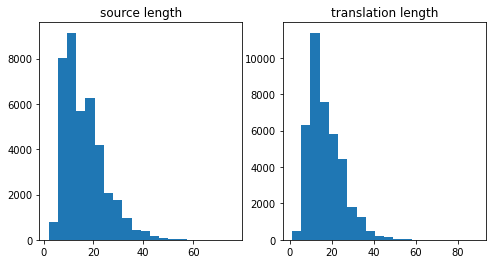

In [14]:
src_length = map(len, [vars(x)['src'] for x in train_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in train_data.examples])

print('Length distribution in Train data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

Length distribution in Test data


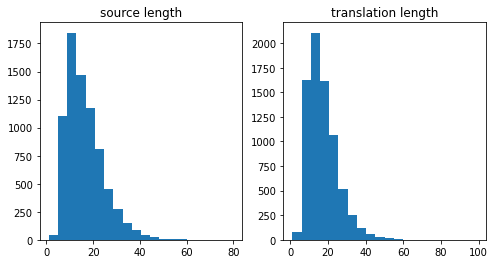

In [15]:
src_length = map(len, [vars(x)['src'] for x in test_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in test_data.examples])

print('Length distribution in Test data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

### Model side
__Here comes simple pipeline of NMT model learning. It almost copies the week03 practice__

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [17]:
device

device(type='cuda')

In [18]:
def _len_sort_key(x):
    return len(x.src)

BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)

In [19]:
for x in train_iterator:
    break
print(x)
print(x.src.shape, x.trg.shape)


[torchtext.legacy.data.batch.Batch of size 128]
	[.trg]:[torch.cuda.LongTensor of size 39x128 (GPU 0)]
	[.src]:[torch.cuda.LongTensor of size 42x128 (GPU 0)]
torch.Size([42, 128]) torch.Size([39, 128])


## Seq2Seq with simle encoder and decoder

In [20]:
import my_network
Encoder = my_network.Encoder
Decoder = my_network.Decoder
Seq2Seq = my_network.Seq2Seq

In [21]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

# dont forget to put the model to the right device
model = Seq2Seq(enc, dec, device).to(device)

In [22]:
def init_weights(m):
    # <YOUR CODE HERE>
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)
        
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(9244, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(6702, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (fc_out): Linear(in_features=512, out_features=6702, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [23]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 14,876,718 trainable parameters


In [24]:
PAD_IDX = TRG.vocab.stoi['<pad>']
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [25]:
def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()
    
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]
        
        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].view(-1)
        
        #trg = [(trg sent len - 1) * batch size]
        #output = [(trg sent len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        # Let's clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()

        
    return epoch_loss / len(iterator)

In [26]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    history = []
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]

            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)

            #trg = [(trg sent len - 1) * batch size]
            #output = [(trg sent len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [27]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [28]:
train_history = []
valid_history = []

N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

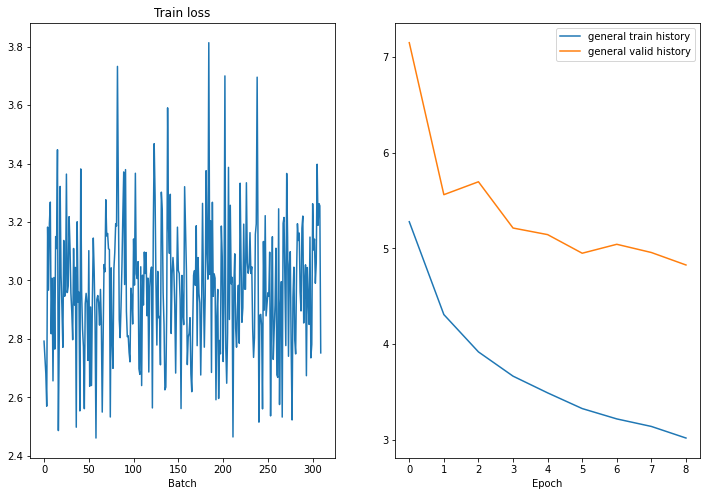

Epoch: 10 | Time: 1m 18s
	Train Loss: 2.969 | Train PPL:  19.469
	 Val. Loss: 4.819 |  Val. PPL: 123.841


In [29]:
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

__Let's take a look at our network quality__:

In [30]:
#del utils

In [31]:
import utils
import imp
imp.reload(utils)
generate_translation = utils.generate_translation
remove_tech_tokens = utils.remove_tech_tokens
get_text = utils.get_text
flatten = utils.flatten

In [32]:
batch = next(iter(test_iterator))

In [33]:
for idx in [1,2]:
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation(src, trg, model, TRG.vocab)

Original: the property offers free parking .
Generated: bath .

Original: you will find a 24 - hour front desk at the property .
Generated: the a 24 - hour front desk .



In [34]:
from nltk.translate.bleu_score import corpus_bleu

#     """ Estimates corpora-level BLEU score of model's translations given inp and reference out """
#     translations, _ = model.translate_lines(inp_lines, **flags)
#     # Note: if you experience out-of-memory error, split input lines into batches and translate separately
#     return corpus_bleu([[ref] for ref in out_lines], translations) * 100

In [35]:
import tqdm

In [36]:
original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output = model(src, trg, 0) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)
        
        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T])

# original_text = flatten(original_text)
# generated_text = flatten(generated_text)

59it [00:03, 17.20it/s]


In [37]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

12.031774590037417

Достаточно маленькое значение bleu, добавим attention и посмотрим на изменения

Baseline solution BLEU score is quite low. Try to achieve at least 24 BLEU on the test set. The checkpoints are:

*   22 - minimal score to submit the homework, 30% of points
*   good score, 70% of points
*   excellent score, 100% of points



## Seq2Seq with attention

In [48]:
imp.reload(my_network)

<module 'my_network' from '/content/my_network.py'>

In [49]:
Encoder = my_network.Encoder
DecoderAttention = my_network.DecoderAttention
Seq2SeqAttention = my_network.Seq2SeqAttention

In [50]:
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec_attention = DecoderAttention(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

model_attention = Seq2SeqAttention(enc, dec_attention, device).to(device)

In [51]:
model_attention.apply(init_weights)

Seq2SeqAttention(
  (encoder): Encoder(
    (embedding): Embedding(9244, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): DecoderAttention(
    (embedding): Embedding(6702, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (attention): Attention(
      (linear_in): Linear(in_features=512, out_features=512, bias=False)
      (linear_out): Linear(in_features=1024, out_features=512, bias=False)
      (softmax): Softmax(dim=-1)
      (tanh): Tanh()
    )
    (fc_out): Linear(in_features=512, out_features=6702, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [52]:
print(f'The model has {count_parameters(model_attention):,} trainable parameters')

The model has 15,663,150 trainable parameters


In [53]:
optimizer_attention = optim.Adam(model_attention.parameters())
criterion_attention = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

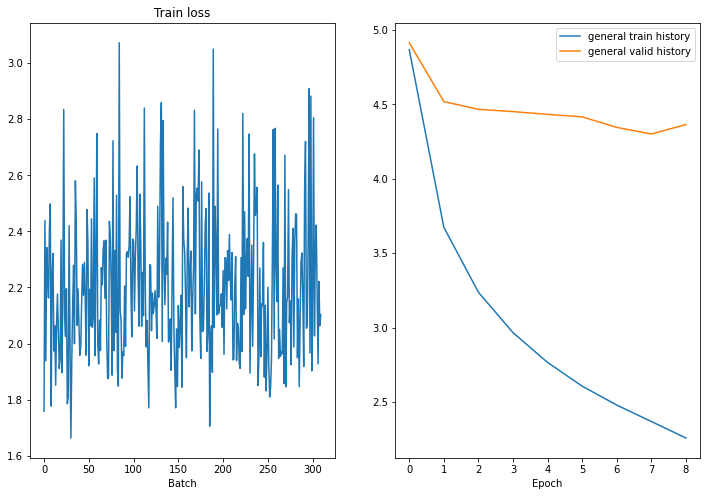

Epoch: 10 | Time: 1m 35s
	Train Loss: 2.199 | Train PPL:   9.014
	 Val. Loss: 4.447 |  Val. PPL:  85.382


In [54]:
train_history = []
valid_history = []

N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model_attention, train_iterator, optimizer_attention, criterion_attention, CLIP, train_history, valid_history)
    valid_loss = evaluate(model_attention, valid_iterator, criterion_attention)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model-attn.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [55]:
batch = next(iter(test_iterator))

In [56]:
for idx in [1,2]:
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation(src, trg, model_attention, TRG.vocab)

Original: the property offers free parking .
Generated: the property offers free parking .

Original: you will find a 24 - hour front desk at the property .
Generated: 24 - hour reception is open 24 hours a day .



In [57]:
original_text = []
generated_text = []
model_attention.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output = model_attention(src, trg, 0) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)
        
        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T])

# original_text = flatten(original_text)
# generated_text = flatten(generated_text)

59it [00:03, 15.49it/s]


In [58]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

30.11304322761926

Ура! Получилось больше, чем 29:)

Отсюда видно, насколько добавление attention улучшает качество работы модели

## The same seq2seq with lr_scheduler

In [74]:
enc_lr = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec_attention_lr = DecoderAttention(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

model_attention_lr = Seq2SeqAttention(enc_lr, dec_attention_lr, device).to(device)

In [75]:
model_attention_lr.apply(init_weights)

Seq2SeqAttention(
  (encoder): Encoder(
    (embedding): Embedding(9244, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): DecoderAttention(
    (embedding): Embedding(6702, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (attention): Attention(
      (linear_in): Linear(in_features=512, out_features=512, bias=False)
      (linear_out): Linear(in_features=1024, out_features=512, bias=False)
      (softmax): Softmax(dim=-1)
      (tanh): Tanh()
    )
    (fc_out): Linear(in_features=512, out_features=6702, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [76]:
print(f'The model has {count_parameters(model_attention_lr):,} trainable parameters')

The model has 15,663,150 trainable parameters


In [77]:
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

In [78]:
optimizer_attention_lr = optim.Adam(model_attention_lr.parameters())
criterion_attention_lr = nn.CrossEntropyLoss(ignore_index = PAD_IDX)
lr_scheduler_attention = ReduceLROnPlateau(optimizer=optimizer_attention_lr, patience=2, factor=0.2)

In [68]:
def train_model(model, train_iterator, valid_iterator, optimizer, criterion,
                lr_scheduler, n_epochs, clip, model_name="model.pth"):
    
    train_history = []
    valid_history = []
    best_valid_loss = float('inf')

    for epoch in range(n_epochs):
        
        start_time = time.time()
        
        train_loss = train(model, train_iterator, optimizer, criterion, clip, train_history, valid_history)
        valid_loss = evaluate(model, valid_iterator, criterion)

        lr_scheduler.step(valid_loss)
        
        end_time = time.time()
        
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), model_name)
        
        train_history.append(train_loss)
        valid_history.append(valid_loss)
        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

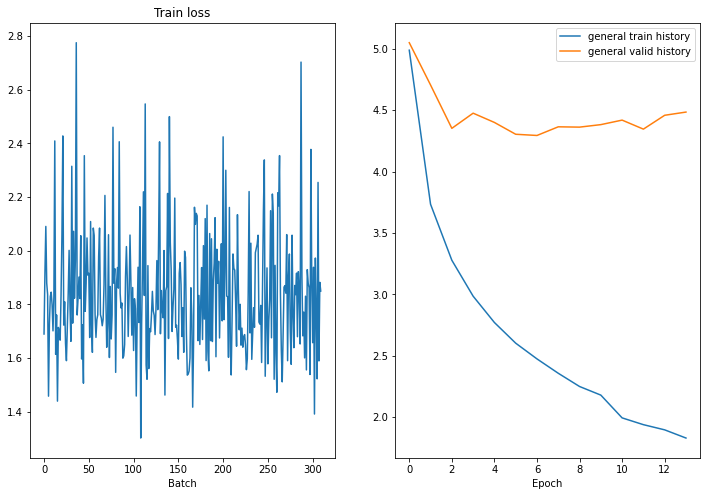

Epoch: 15 | Time: 1m 34s
	Train Loss: 1.841 | Train PPL:   6.301
	 Val. Loss: 4.469 |  Val. PPL:  87.243


In [79]:
train_model(model_attention_lr, train_iterator, valid_iterator, 
            optimizer_attention_lr, criterion_attention_lr, lr_scheduler_attention, 
            n_epochs=15, clip=1, model_name="model_attention_lr.pt")

In [80]:
batch = next(iter(test_iterator))

In [81]:
for idx in [1,2]:
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation(src, trg, model_attention_lr, TRG.vocab)

Original: the property offers free parking .
Generated: the property offers free parking .

Original: you will find a 24 - hour front desk at the property .
Generated: you will find a 24 - hour front desk at the property .



In [82]:
original_text = []
generated_text = []
model_attention_lr.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output = model_attention_lr(src, trg, 0) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)
        
        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T])

# original_text = flatten(original_text)
# generated_text = flatten(generated_text)

59it [00:03, 15.40it/s]


In [83]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

31.41634416317945

С помощью lr_scheduler получилось улучшить bleu чуть больше, чем на 1 (ну и эпох я сделала чуть больше)

## Convolutional Encoder with positional encoding and simple Decoder (just to compare with simple seq2seq)



In [96]:
imp.reload(my_network)

<module 'my_network' from '/content/my_network.py'>

In [97]:
ConvEncoder = my_network.ConvEncoder
Decoder = my_network.Decoder
Seq2SeqConvEncoder = my_network.Seq2SeqConvEncoder

In [121]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 512
DEC_EMB_DIM = 512
ENC_HID_DIM = 512
DEC_HID_DIM = 512
N_ENC_LAYERS = 4
N_DEC_LAYERS = 2
KERNEL_SIZE = 3
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc_cnn = ConvEncoder(device=device,
                     input_dim=INPUT_DIM,
                     emb_dim=ENC_EMB_DIM,
                     hid_dim=ENC_HID_DIM,
                     num_layers=N_ENC_LAYERS,
                     out_dim=DEC_HID_DIM*4,
                     pos_encoding=True,
                     dropout_p=ENC_DROPOUT,
                     kernel_size=KERNEL_SIZE)

dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, DEC_HID_DIM, N_DEC_LAYERS, DEC_DROPOUT)

cnn_model = Seq2SeqConvEncoder(enc_cnn, dec, device).to(device)
print(f'The model has {count_parameters(cnn_model):,} trainable parameters')

The model has 20,003,374 trainable parameters


In [122]:
cnn_model.apply(init_weights)

Seq2SeqConvEncoder(
  (encoder): ConvEncoder(
    (embedding): Embedding(9244, 512)
    (conv): ModuleList(
      (0): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(1,))
      (2): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(1,))
      (3): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(1,))
    )
    (projection_layer): Linear(in_features=512, out_features=2048, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
    (pooling): AdaptiveMaxPool1d(output_size=1)
    (relu): ReLU()
  )
  (decoder): Decoder(
    (embedding): Embedding(6702, 512)
    (rnn): LSTM(512, 512, num_layers=2, dropout=0.5)
    (fc_out): Linear(in_features=512, out_features=6702, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [123]:
optimizer_cnn = optim.AdamW(cnn_model.parameters())
criterion_cnn = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
lr_scheduler_cnn = ReduceLROnPlateau(optimizer=optimizer_cnn, patience=2, factor=0.2)

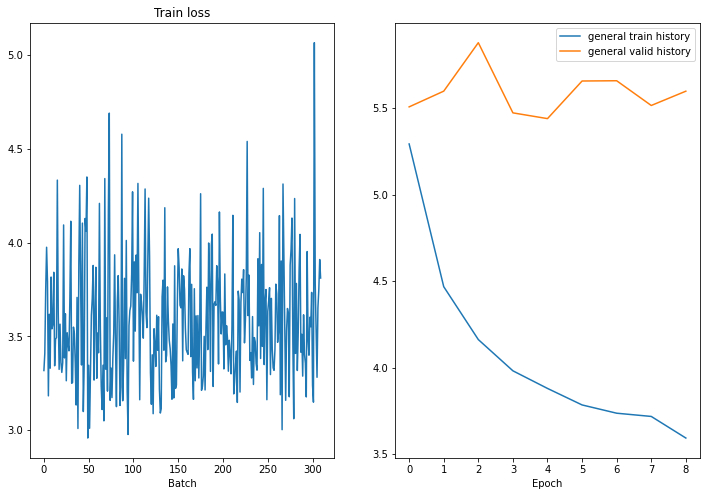

Epoch: 10 | Time: 1m 21s
	Train Loss: 3.578 | Train PPL:  35.804
	 Val. Loss: 5.409 |  Val. PPL: 223.425


In [124]:
train_model(cnn_model, train_iterator, valid_iterator, 
            optimizer_cnn, criterion_cnn, lr_scheduler_cnn, 
            n_epochs=10, clip=1, model_name="cnn_model.pt")

In [125]:
batch = next(iter(test_iterator))

In [126]:
for idx in [1,2]:
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation(src, trg, cnn_model, TRG.vocab)

Original: the property offers free parking .
Generated: the is is a a - minute drive from the .

Original: you will find a 24 - hour front desk at the property .
Generated: the is is a a - minute drive from the .



In [127]:
original_text = []
generated_text = []
cnn_model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output = cnn_model(src, trg, 0) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)
        
        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T])

# original_text = flatten(original_text)
# generated_text = flatten(generated_text)

59it [00:03, 15.13it/s]


In [128]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

1.2927731168033485

Как видно, модель с энкодером на CNN как-то очень плохо работает, даже с добавлением pos_encoding. Добавление LSTM после всех Conv1d слоев, наверное, могло бы улучшить ситуацию, потому что добавилось бы начальное скрытое состояние для декодера, передающее информацию 

Эксперементы с количеством слоев и размером ядра дают примерно одинаковые плозхие результаты

